<a href="https://colab.research.google.com/github/Anaya-Koirala/Music-Generating-LSTM-EE/blob/main/EE_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi music21 pandas numpy matplotlib seaborn

In [ ]:
import pretty_midi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import glob
from collections import defaultdict, Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pretty_midi.pretty_midi.MAX_TICK = 1e10

# File Paths

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def load_and_process_midis(midi_files):
    all_notes = []
    for midi_file in midi_files:
        notes_df = midi_to_notes(midi_file)
        all_notes.append(notes_df)
    return all_notes

# Plot Distributions

In [ ]:
def plot_distributions(notes: pd.DataFrame, title: str, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.suptitle(title)

    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))



def plot_total_distribution(all_notes,  title: str, drop_percentile=2.5):
    combined_notes = pd.concat(all_notes)
    plot_distributions(combined_notes, f'Total Distribution of {title} MIDI Files', drop_percentile)

def plot_average_distribution(all_notes, title: str, drop_percentile=2.5):
    combined_notes = pd.concat(all_notes)

    avg_notes = pd.DataFrame({
        'pitch': combined_notes.groupby(combined_notes.index).pitch.mean(),
        'step': combined_notes.groupby(combined_notes.index).step.mean(),
        'duration': combined_notes.groupby(combined_notes.index).duration.mean()
    })

    plt.figure(figsize=[15, 5])
    plt.suptitle(f'Average Distribution of {title} MIDI Files')

    plt.subplot(1, 3, 1)
    sns.histplot(avg_notes, x="pitch", bins=20)
    plt.xlabel('Average Pitch')

    plt.subplot(1, 3, 2)
    max_step = np.percentile(avg_notes['step'], 100 - drop_percentile)
    sns.histplot(avg_notes, x="step", bins=np.linspace(0, max_step, 21))
    plt.xlabel('Average Step')

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(avg_notes['duration'], 100 - drop_percentile)
    sns.histplot(avg_notes, x="duration", bins=np.linspace(0, max_duration, 21))
    plt.xlabel('Average Duration')

    plt.tight_layout()
    plt.show()



def plot_sample_distributions(num_samples=1, drop_percentile=2.5):
    for i in range(num_samples-1):

        random_index = random.randint(0,len(generated_midi_files)-1)
        plot_distributions(midi_to_notes(generated_midi_files[random_index]), f'Distribution of Generated MIDI File {generated_midi_files[random_index]}')
        plot_distributions(midi_to_notes(dataset_midi_files[random_index]), f'Distribution of Dataset MIDI File {dataset_midi_files[random_index]}')

# Plot Piano Roll

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count = None):

    title = f'Piano Roll of Sample Track'
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

def plot_average_piano_roll(all_notes):
    combined_notes = pd.concat(all_notes)
    avg_notes = pd.DataFrame({
        'pitch': combined_notes.groupby(combined_notes.index).pitch.mean(),
        'start': combined_notes.groupby(combined_notes.index).start.mean(),
        'end': combined_notes.groupby(combined_notes.index).end.mean()
    })
    title = 'Average Piano Roll'
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([avg_notes['pitch'], avg_notes['pitch']], axis=0)
    plot_start_stop = np.stack([avg_notes['start'], avg_notes['end']], axis=0)
    plt.plot(
      plot_start_stop, plot_pitch, color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)
    plt.show()

# Melody Detection

In [ ]:
def detect_melodies(notes: pd.DataFrame, min_length=3, min_repeats=2):
    sequence = list(zip(notes['pitch'], notes['step']))
    subsequences = defaultdict(int)
    for i in range(len(sequence)):
        for j in range(i + min_length, len(sequence) + 1):
            subsequence = tuple(sequence[i:j])
            subsequences[subsequence] += 1
    melodies = {subseq: count for subseq, count in subsequences.items() if count >= min_repeats}
    return melodies

def detect_sample_melodies(sample_notes, min_length=3, min_repeats=2):
    sample_melodies = detect_melodies(sample_notes, min_length, min_repeats)
    print(f"Number of distinct melodies: {len(sample_melodies)}")
    for melody, count in sample_melodies.items():
        print(f"Melody {melody} repeated {count} times")

def get_total_melodies(notes_list):
    total_melodies = 0
    for notes in notes_list:
        melodies = detect_melodies(notes)
        total_melodies += len(melodies)
    return total_melodies

def get_average_melodies(notes_list,midi_files):
    return get_total_melodies(notes_list)/len(midi_files)

## Time Signature

In [ ]:
def get_time_signature(pm):
    time_signature_changes = pm.time_signature_changes
    if time_signature_changes:
        time_signatures = [f"{ts.numerator}/{ts.denominator}" for ts in time_signature_changes]
        most_common_ts = Counter(time_signatures).most_common(1)
        return most_common_ts[0][0] if most_common_ts else None
    return None

def find_average_time_signature(midi_files):
    time_signatures = []
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(midi_file)
        ts = get_time_signature(pm)
        if ts:
            time_signatures.append(ts)

    ts_counter = Counter(time_signatures)

    if ts_counter:
        average_time_signature = ts_counter.most_common(1)[0][0]
    else:
        average_time_signature = None

    return average_time_signature


In [ ]:
!cp -r  '/content/drive/MyDrive/:(/EE/bach_dataset' /content/
!cp -r  '/content/drive/MyDrive/:(/EE/bach_generated' /content/

dataset_midi_files = glob.glob('/content/bach_dataset/processed/*.mid')
generated_midi_files = glob.glob('/content/bach_generated/*.mid')

# Load Dataset and Generated MIDIs

In [ ]:
generated_notes = load_and_process_midis(generated_midi_files)
dataset_notes = load_and_process_midis(dataset_midi_files)

# Output

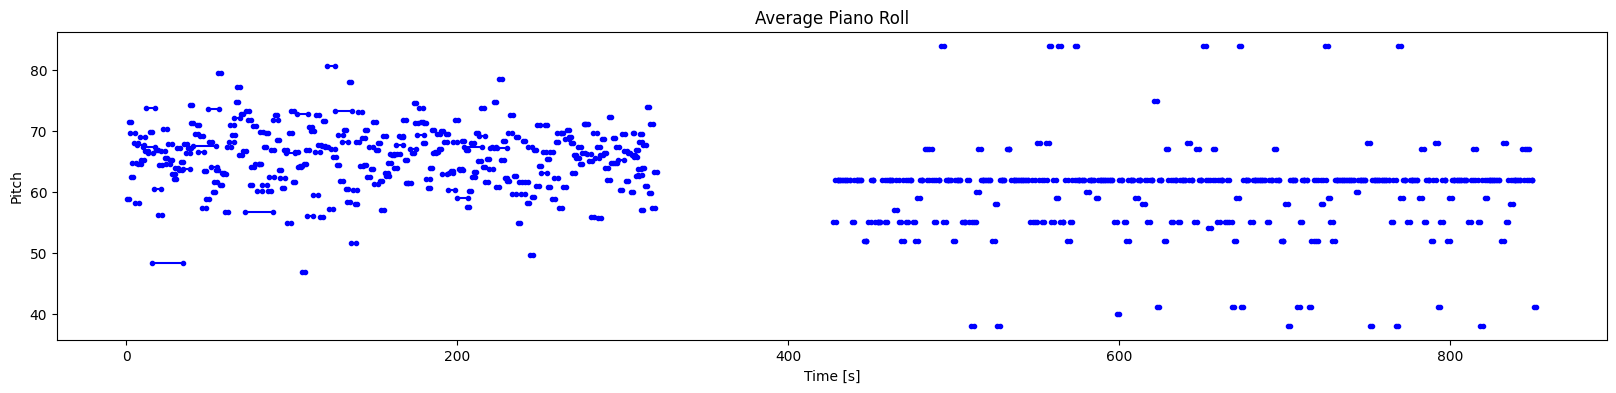

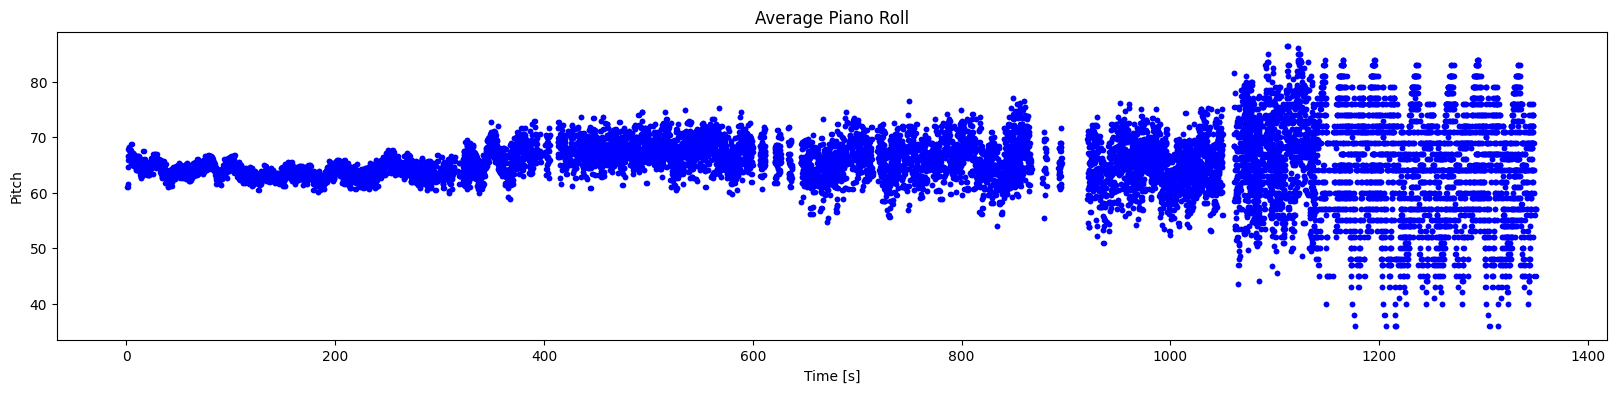

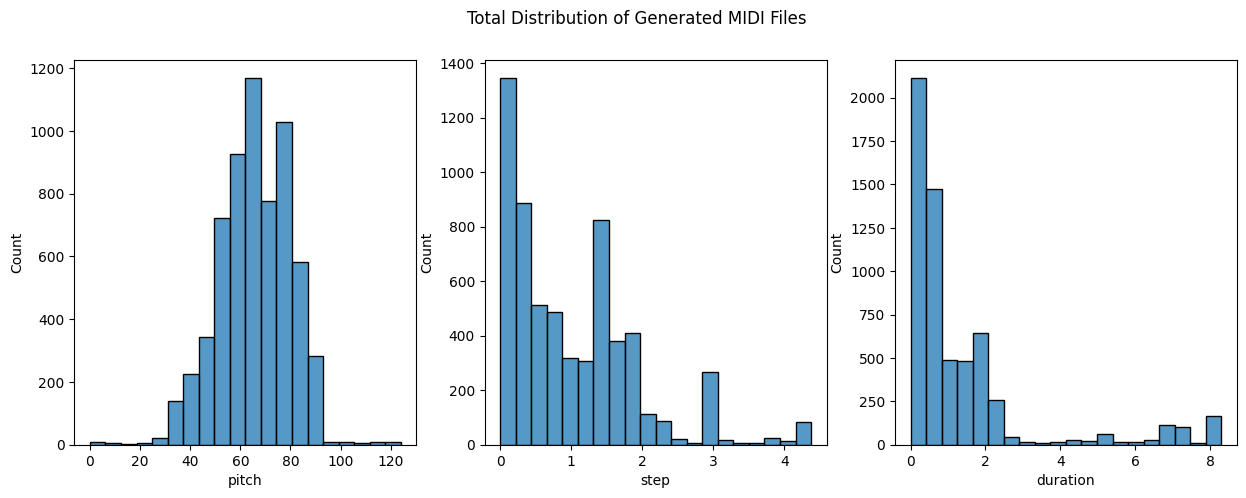

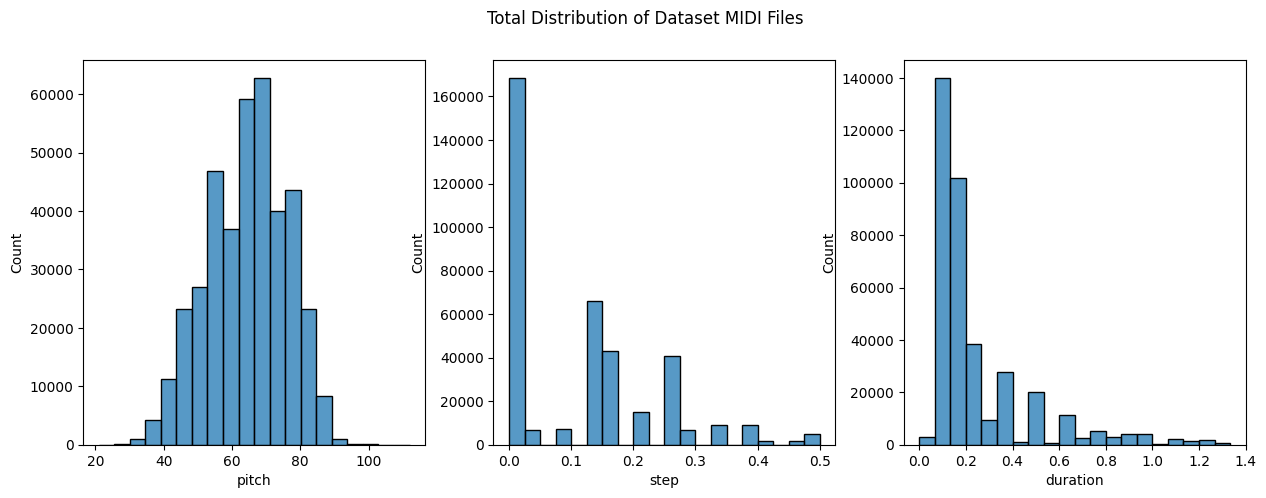

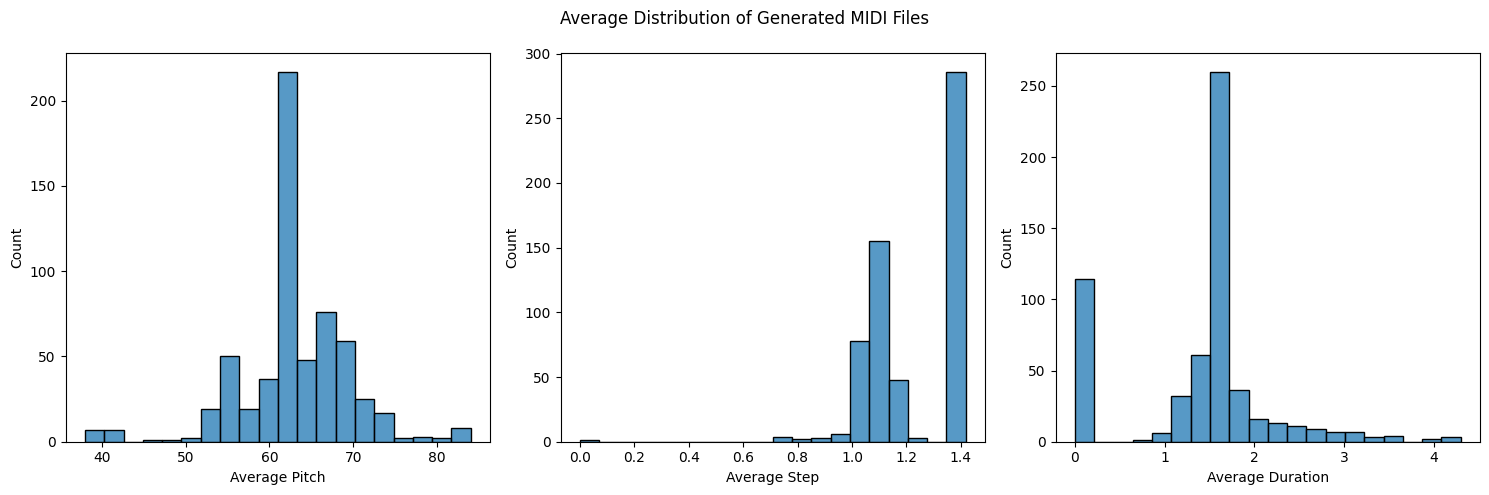

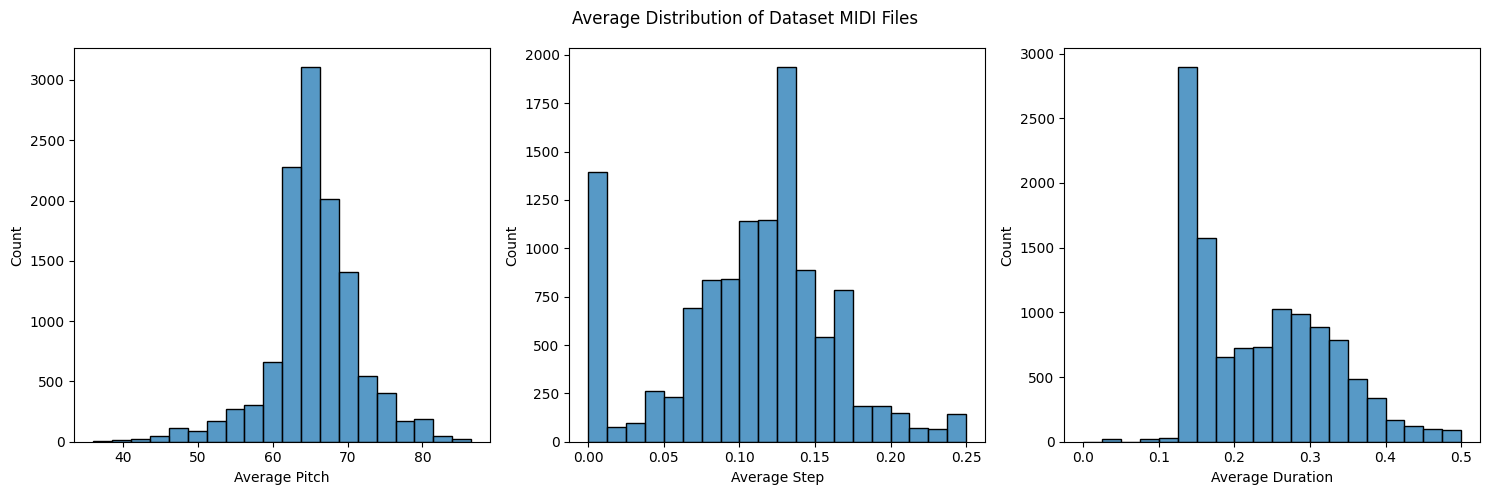

In [ ]:
plot_average_piano_roll(generated_notes)
plot_average_piano_roll(dataset_notes)

plot_total_distribution(generated_notes,'Generated')
plot_total_distribution(dataset_notes, 'Dataset')



plot_sample_distributions()


plot_average_distribution(generated_notes,'Generated')
plot_average_distribution(dataset_notes, 'Dataset')
